## Urban Noise Detection:

In this notebook we tackle the urban noise classification problem.

A Dataset of 8732 labeled .wav files are obtained form (https://urbansounddataset.weebly.com/urbansound.html).

Features are extracted and used to train classification algorithms.

Performance is assessed and discussed.



In [1]:
#import needed libraries

import librosa as lb #used for feature extracion and resampling
import numpy as np 
import matplotlib.pyplot as plt
import librosa.display #builds on matplotlib to draw nice spectrograms.
import IPython.display as ipd #used to play .wav files from notebook
import pandas as pd 
# from scipy.io import wavfile #can be used to import .wav files but does not work on 24 bit depth audio files


import soundfile as sf #soundfile enables loading 24 bit depth audio files.
import time #used to measure code runtime. 
import pickle
import glob
from collections import defaultdict
import urbanNoises

## The first step is visualizing the sounds as numpy arrays. 



In [30]:
info=pd.read_csv('Data/UrbanSound8K.csv')
info.head()


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

## Feature Visualization

We get 1 sounds from each class.

In [31]:
labels=info['class'].unique()

samples=defaultdict(list)

for label in labels:
    sub=info[info['class']==label]
    samples[label].extend(list(sub.slice_file_name.values[[2]]))
    samples[label+'fold'].extend(list(sub.fold.values[[2]]))
    

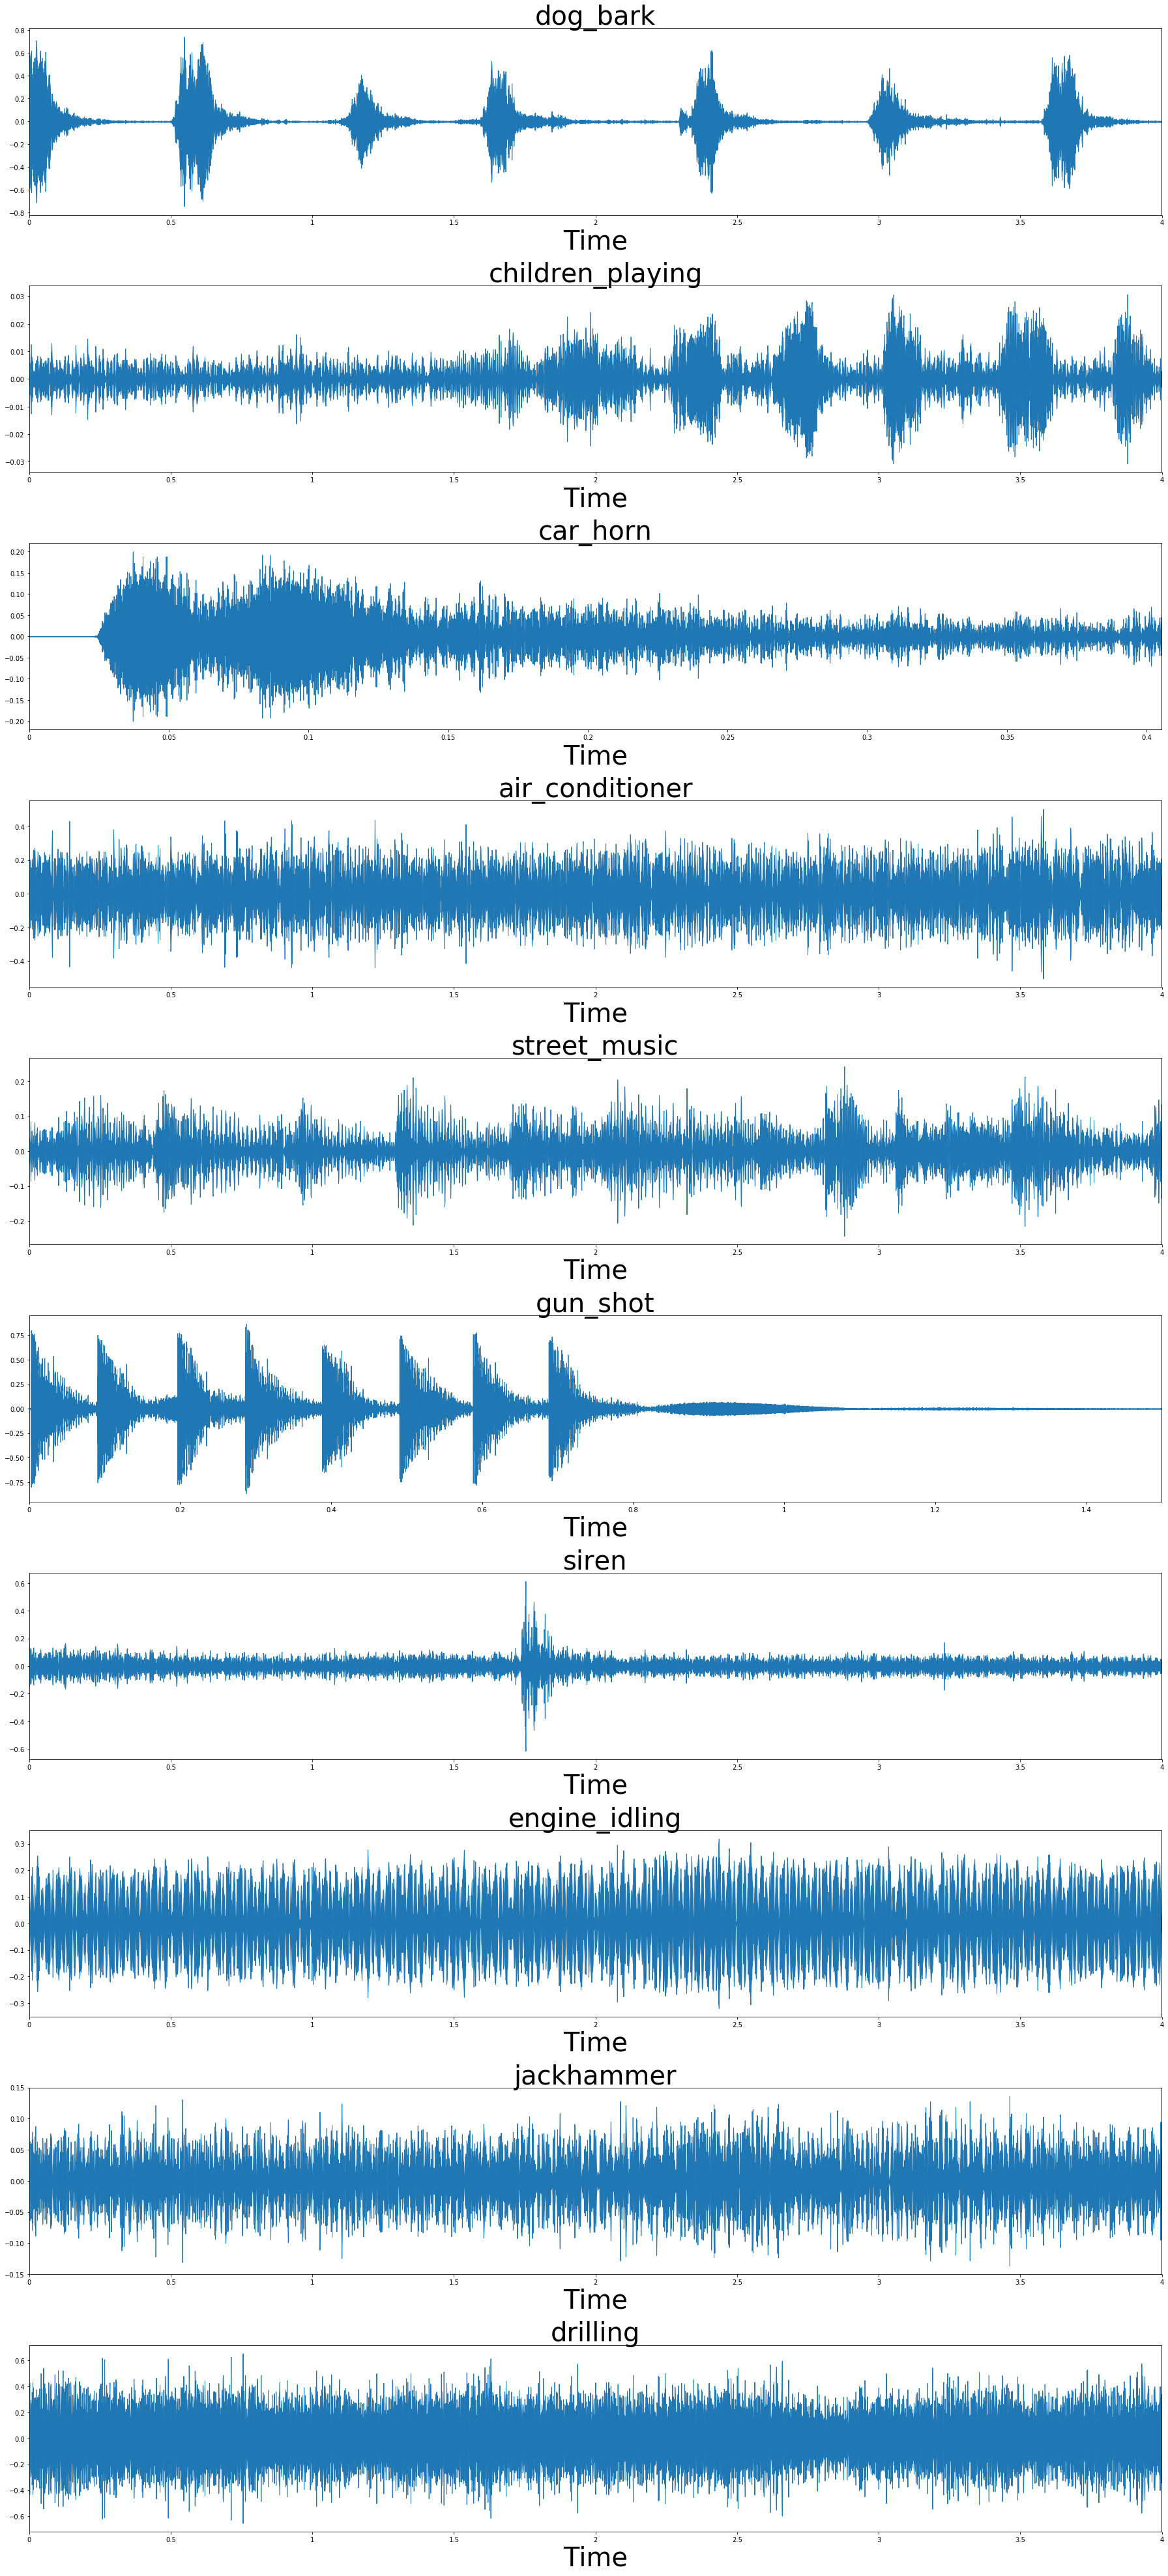

In [29]:
f, axs = plt.subplots(10,1,figsize=(25,55))
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        plt.subplot(10,1,j+i+1)
        lb.display.waveplot(x,sr)
        plt.xlabel('Time',fontsize=40)
        plt.title(label,fontsize=40)

plt.tight_layout()
plt.savefig('plots/soundsAsArrays.png')
plt.show()
        
    

## Mel-Scaled Spectrograms

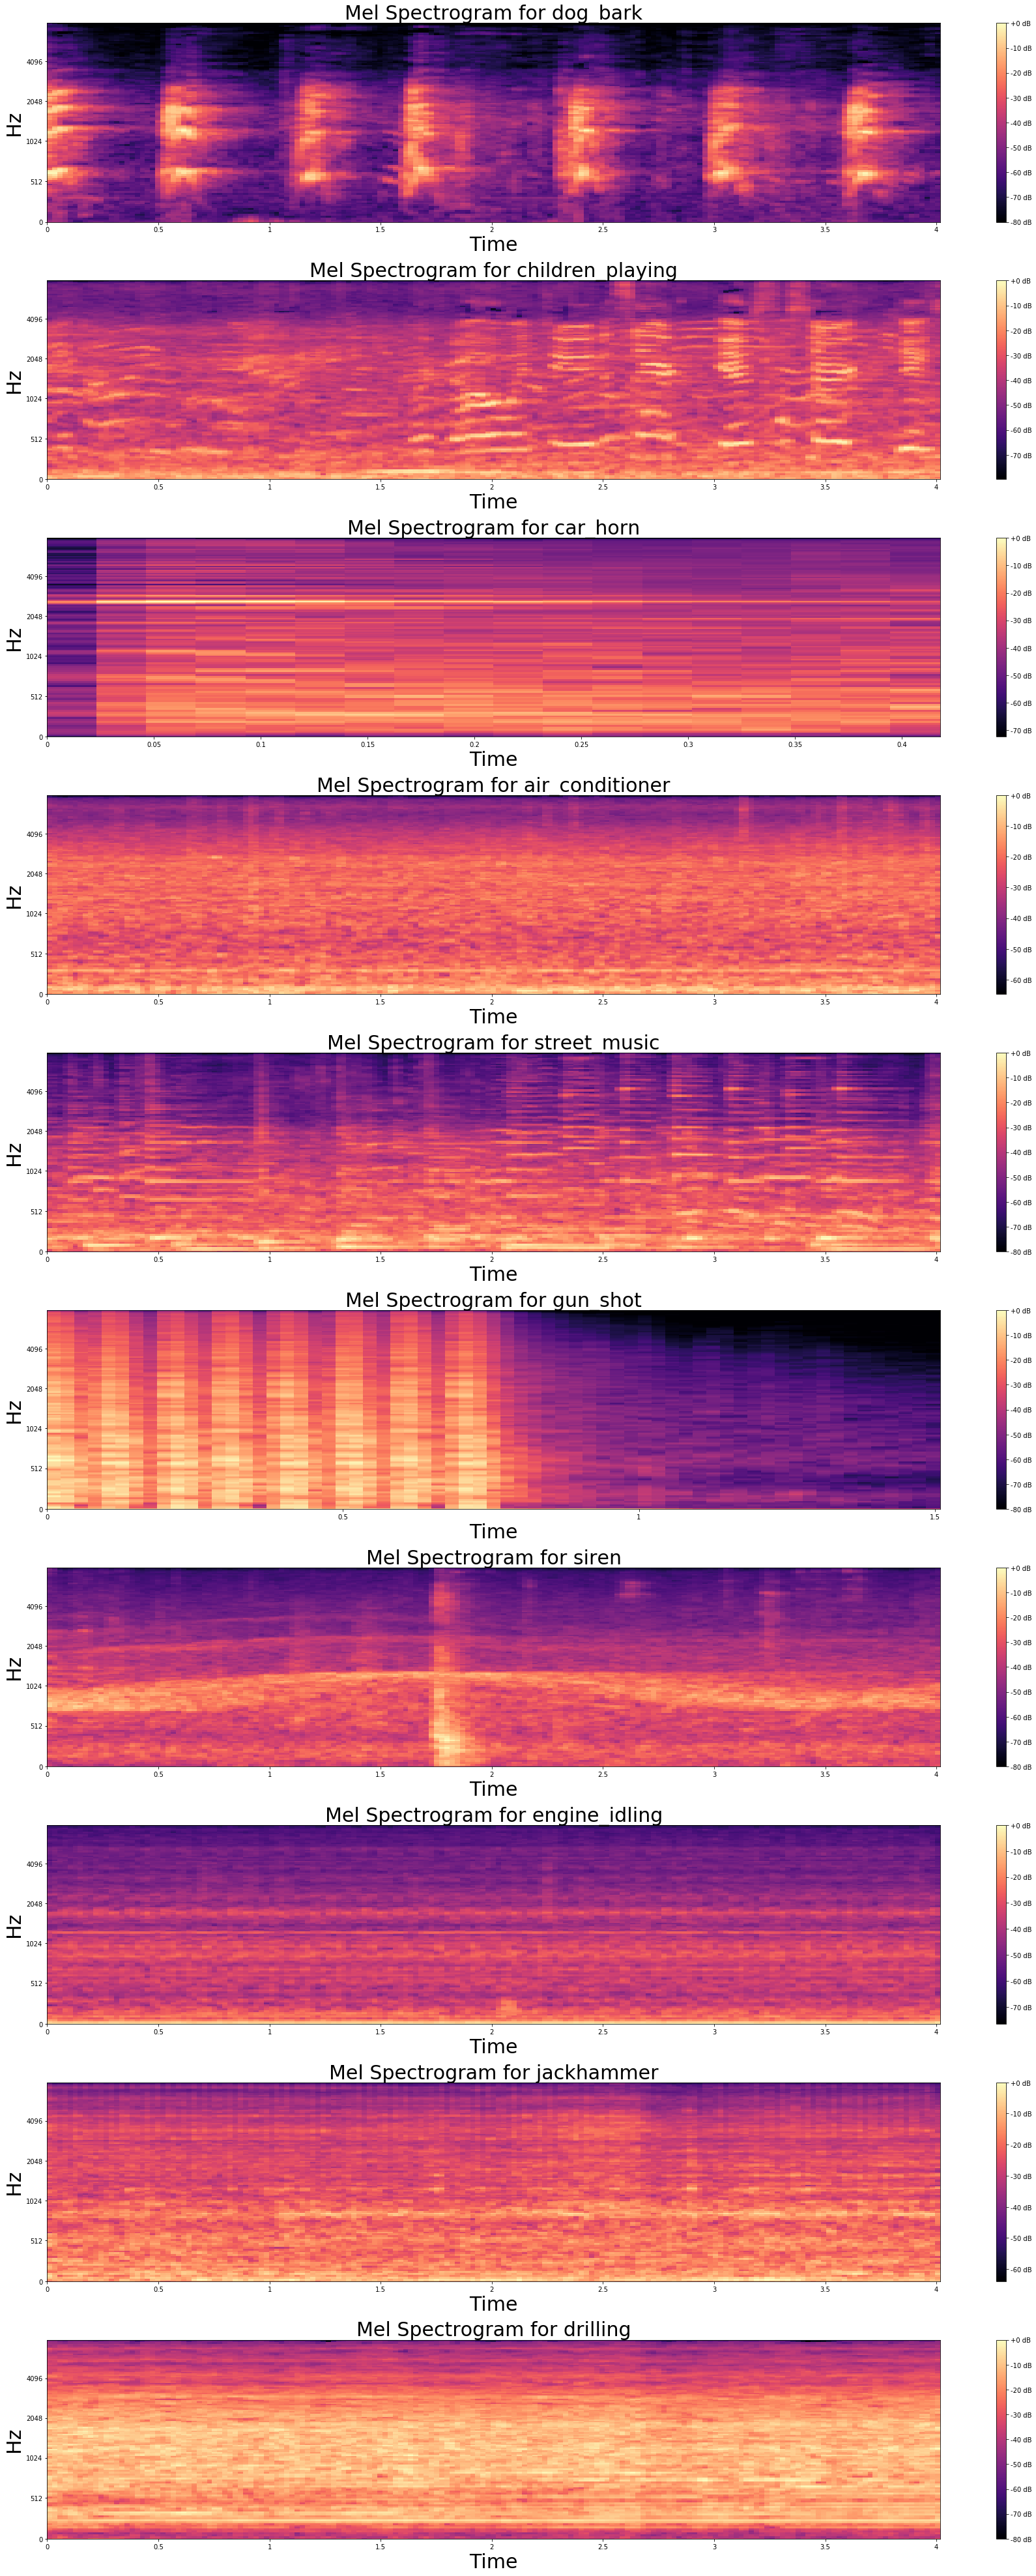

In [44]:
f, axs = plt.subplots(10,1,figsize=(25,55))
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)

        plt.subplot(10,1,j+i+1)
        lb.display.specshow(lb.power_to_db(S,ref=np.max),
                           y_axis='mel',
                            fmax=8000,\
                            x_axis='time')
        plt.ylabel('Hz',fontsize=30)
        plt.xlabel('Time',fontsize=30)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram for {}'.format(label),fontsize=30)
        
plt.tight_layout()
plt.savefig('plots/MelSpectrograms.png')
plt.show()



    

## Mel-Scaled Cepstral Coefficients:

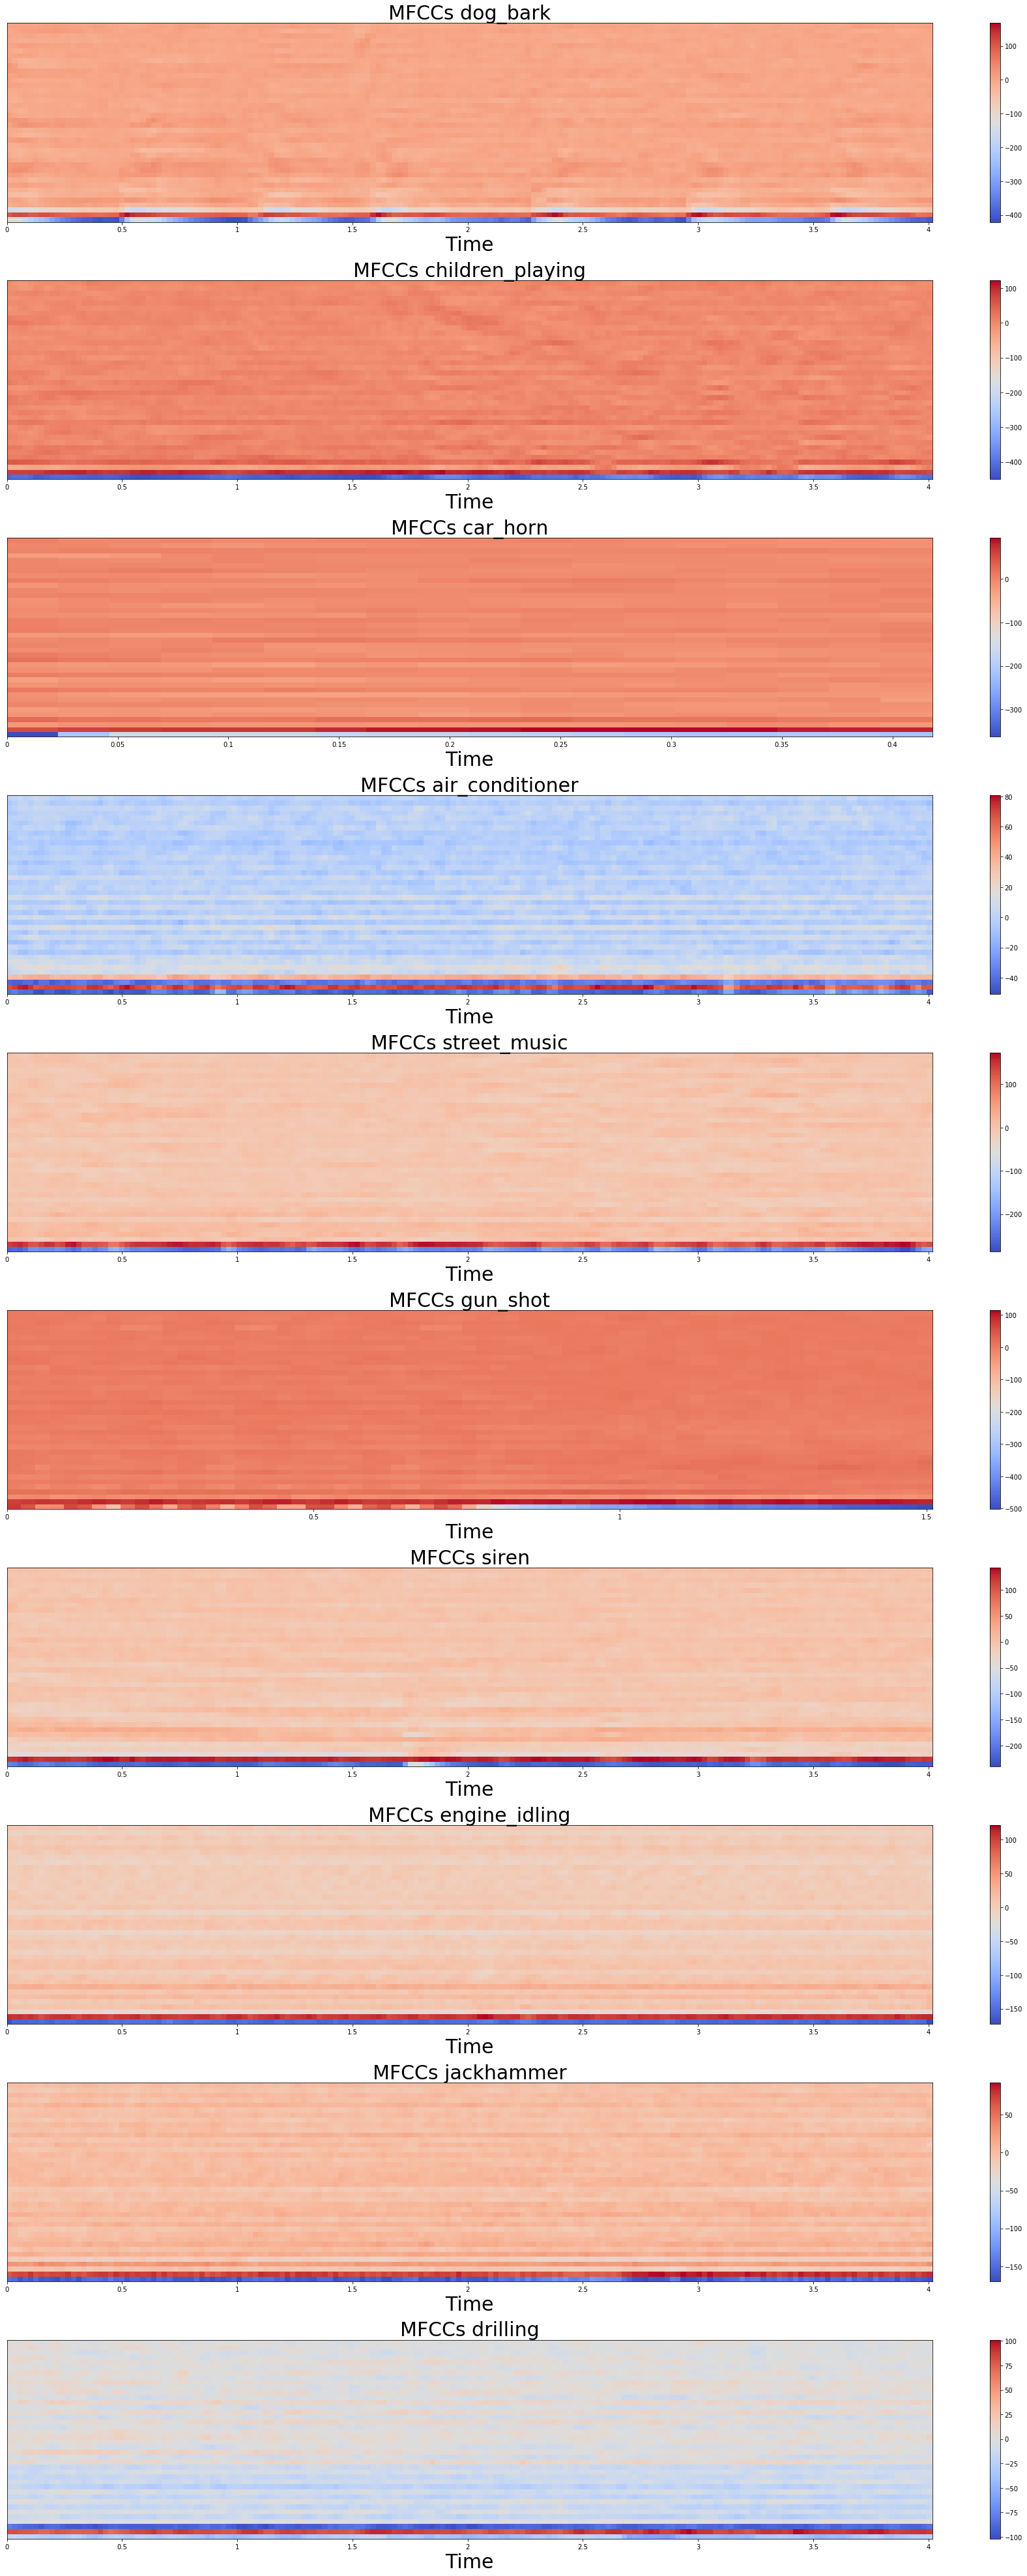

In [51]:
f, axs = plt.subplots(10,1,figsize=(25,55))
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        
        mfcc=lb.feature.mfcc(y=x,sr=sr,n_mfcc=40)
        
        plt.subplot(10,1,j+i+1)
        librosa.display.specshow(mfcc,x_axis='time')
        plt.title('MFCCs {}'.format(label),fontsize=30)
    
        plt.xlabel('Time',fontsize=30)        
        plt.colorbar()

plt.tight_layout()
plt.savefig('plots/MFCC.png')
plt.show()

## Chroma Features

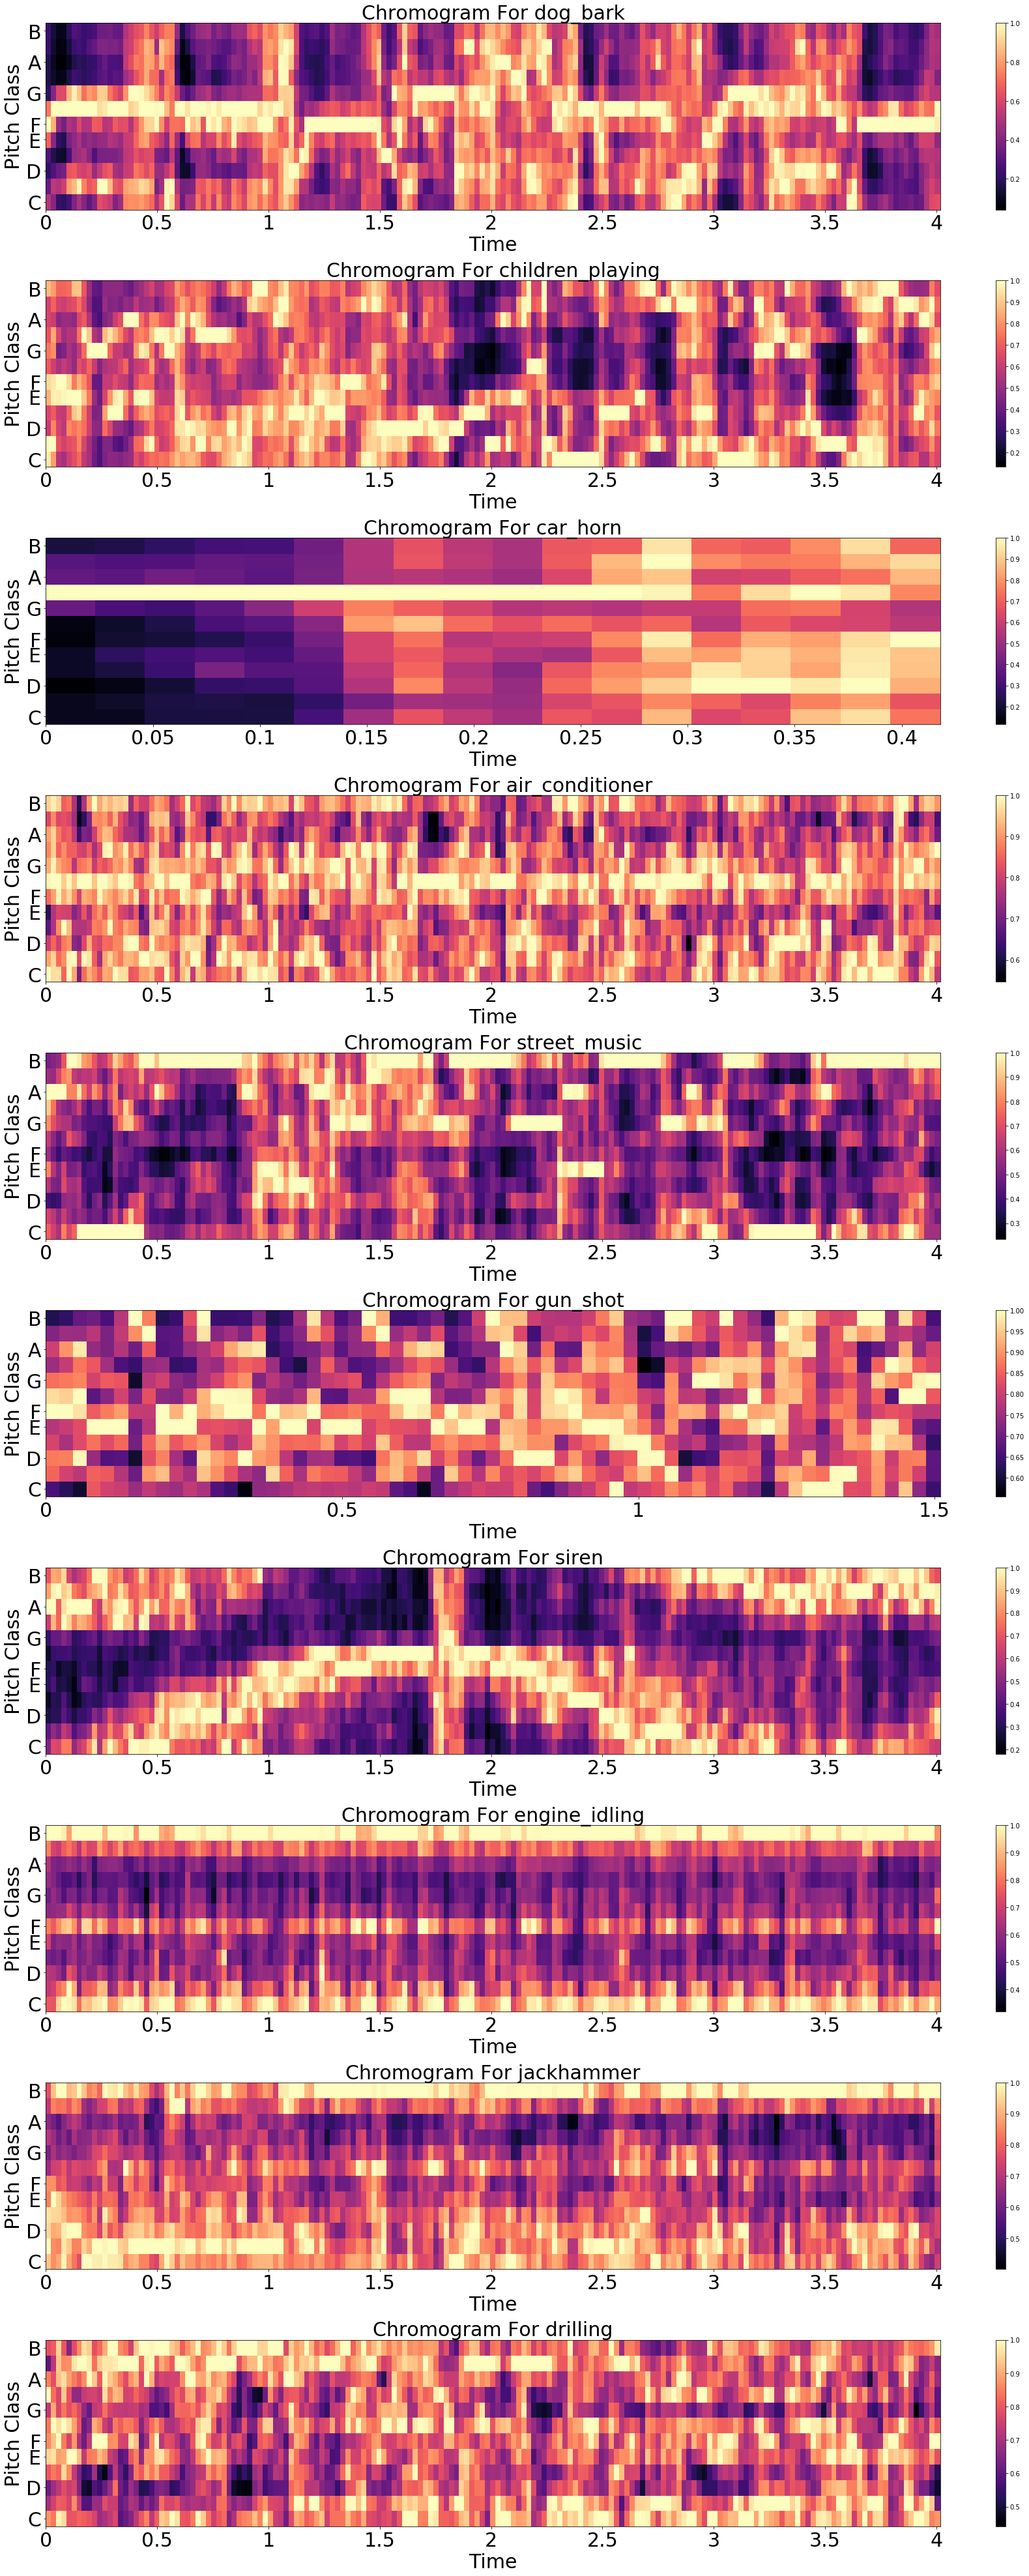

In [59]:
f, axs = plt.subplots(10,1,figsize=(25,55))
fsize=30
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        stft=np.abs(lb.stft(x))
        chroma=lb.feature.chroma_stft(S=stft,sr=sr)
        plt.subplot(10,1,i+j+1)
        librosa.display.specshow(chroma,y_axis='chroma',x_axis='time')
        plt.title('Chromogram For {}'.format(label),fontsize=fsize)
        plt.colorbar()
        plt.ylabel('Pitch Class',fontsize=fsize)
        plt.xlabel('Time',fontsize=fsize)
        plt.tick_params(labelsize=fsize)
        
        
plt.tight_layout()
plt.savefig('plots/Chroma.png')
plt.show()        

## Tonnetz:

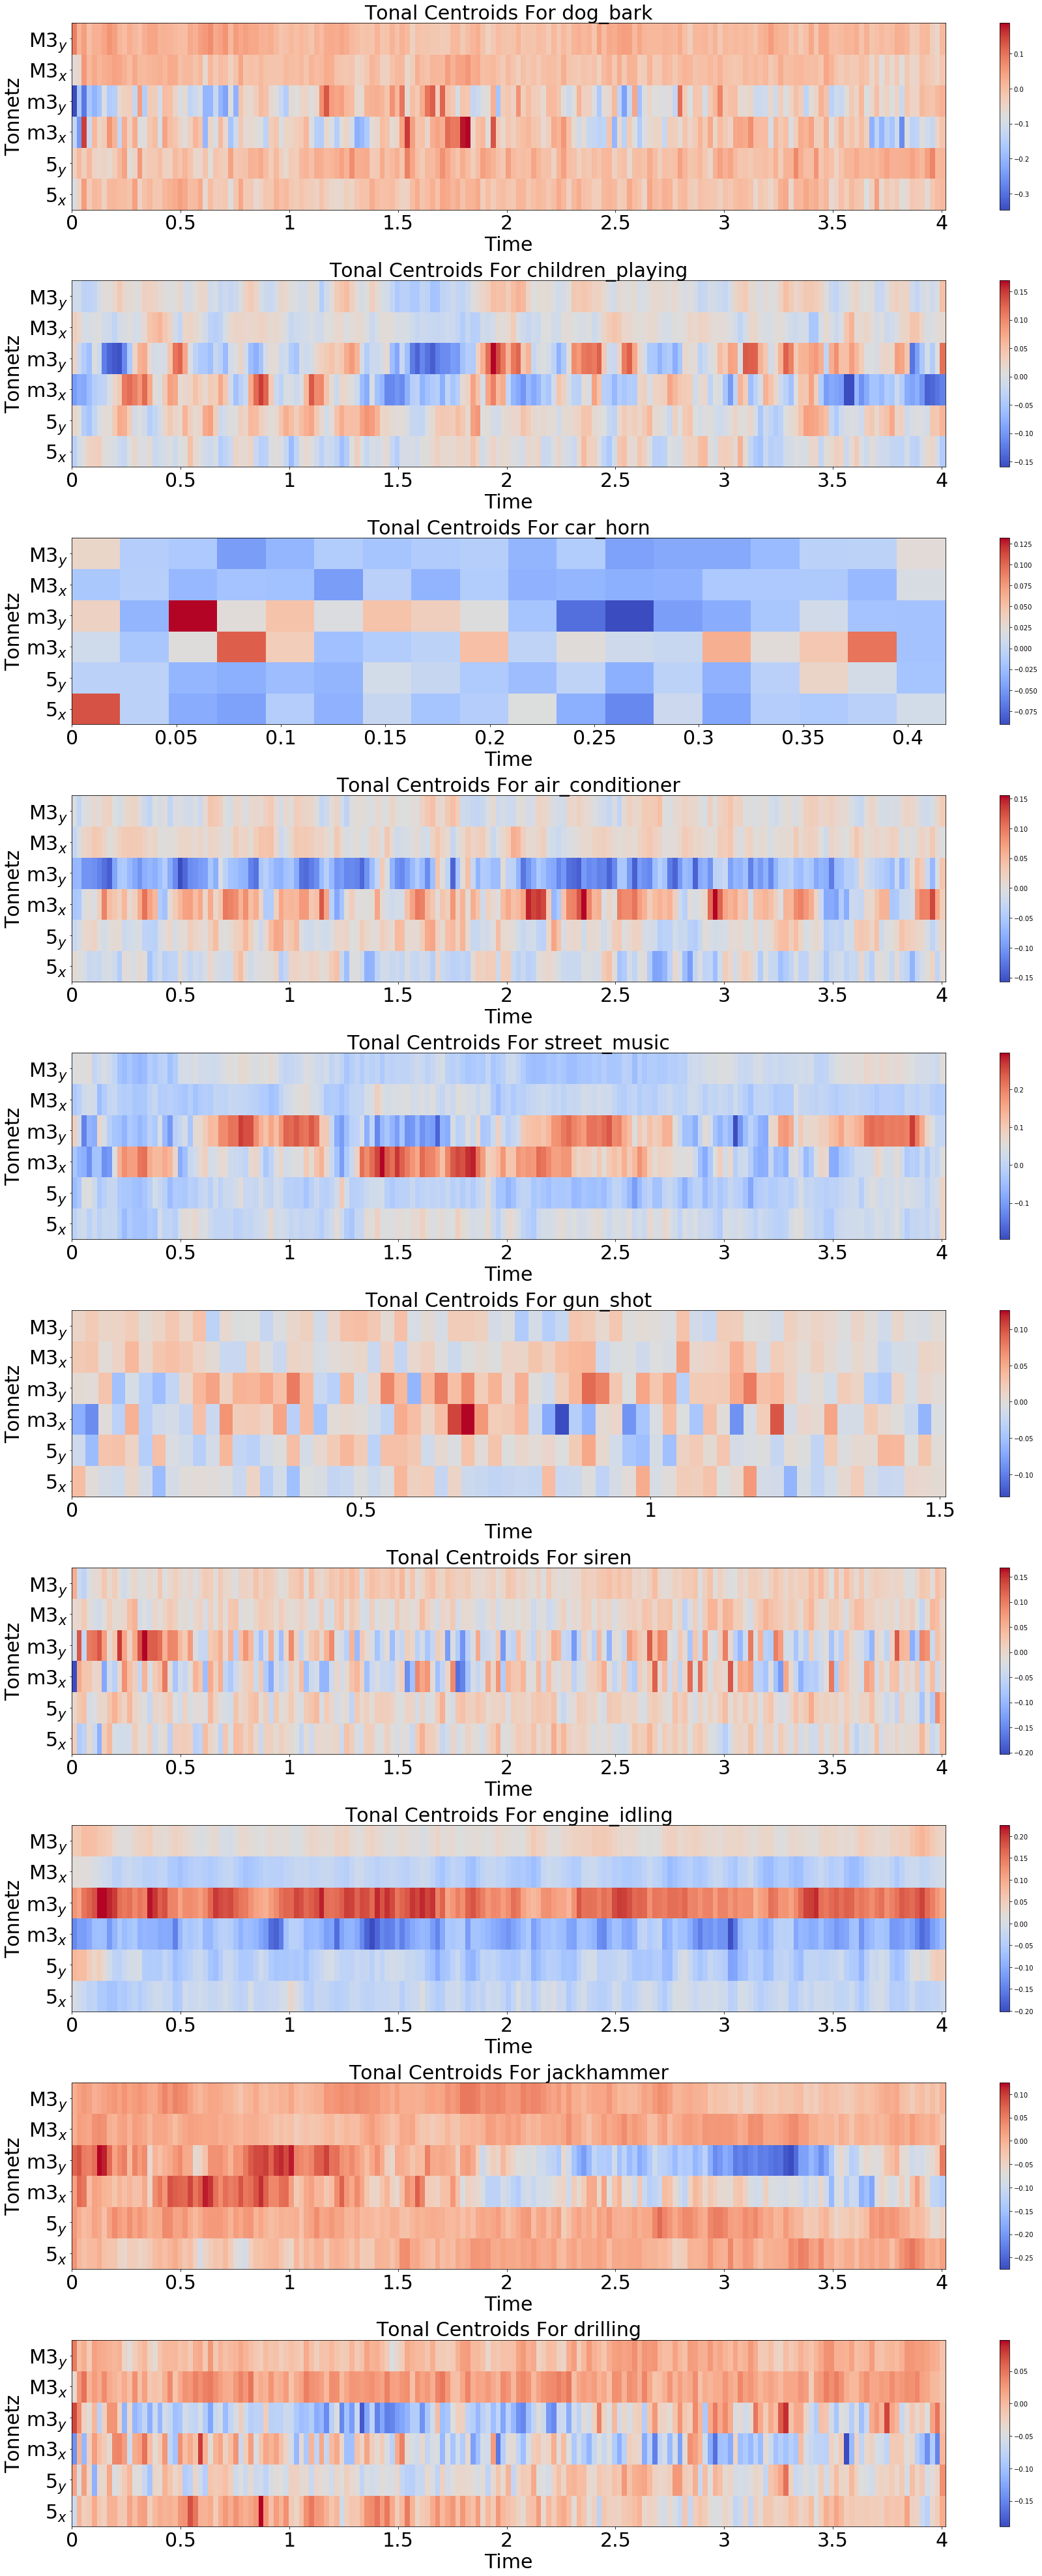

In [64]:
f, axs = plt.subplots(10,1,figsize=(25,55))
fsize=30
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        
        x=lb.effects.harmonic(x)
        tonnetz=lb.feature.tonnetz(y=x,sr=sr)
        
        plt.subplot(10,1,i+j+1)
        librosa.display.specshow(tonnetz,y_axis='tonnetz',x_axis='time')
        plt.title('Tonal Centroids For {}'.format(label),fontsize=fsize)
        plt.ylabel('Tonnetz',fontsize=fsize)
        plt.xlabel('Time',fontsize=fsize)
        plt.colorbar()
        plt.tick_params(labelsize=fsize)

plt.tight_layout()
plt.savefig('plots/Tonnetz.png')
plt.show()

## Temporally Averaging Mel-Scaled Spectrograms

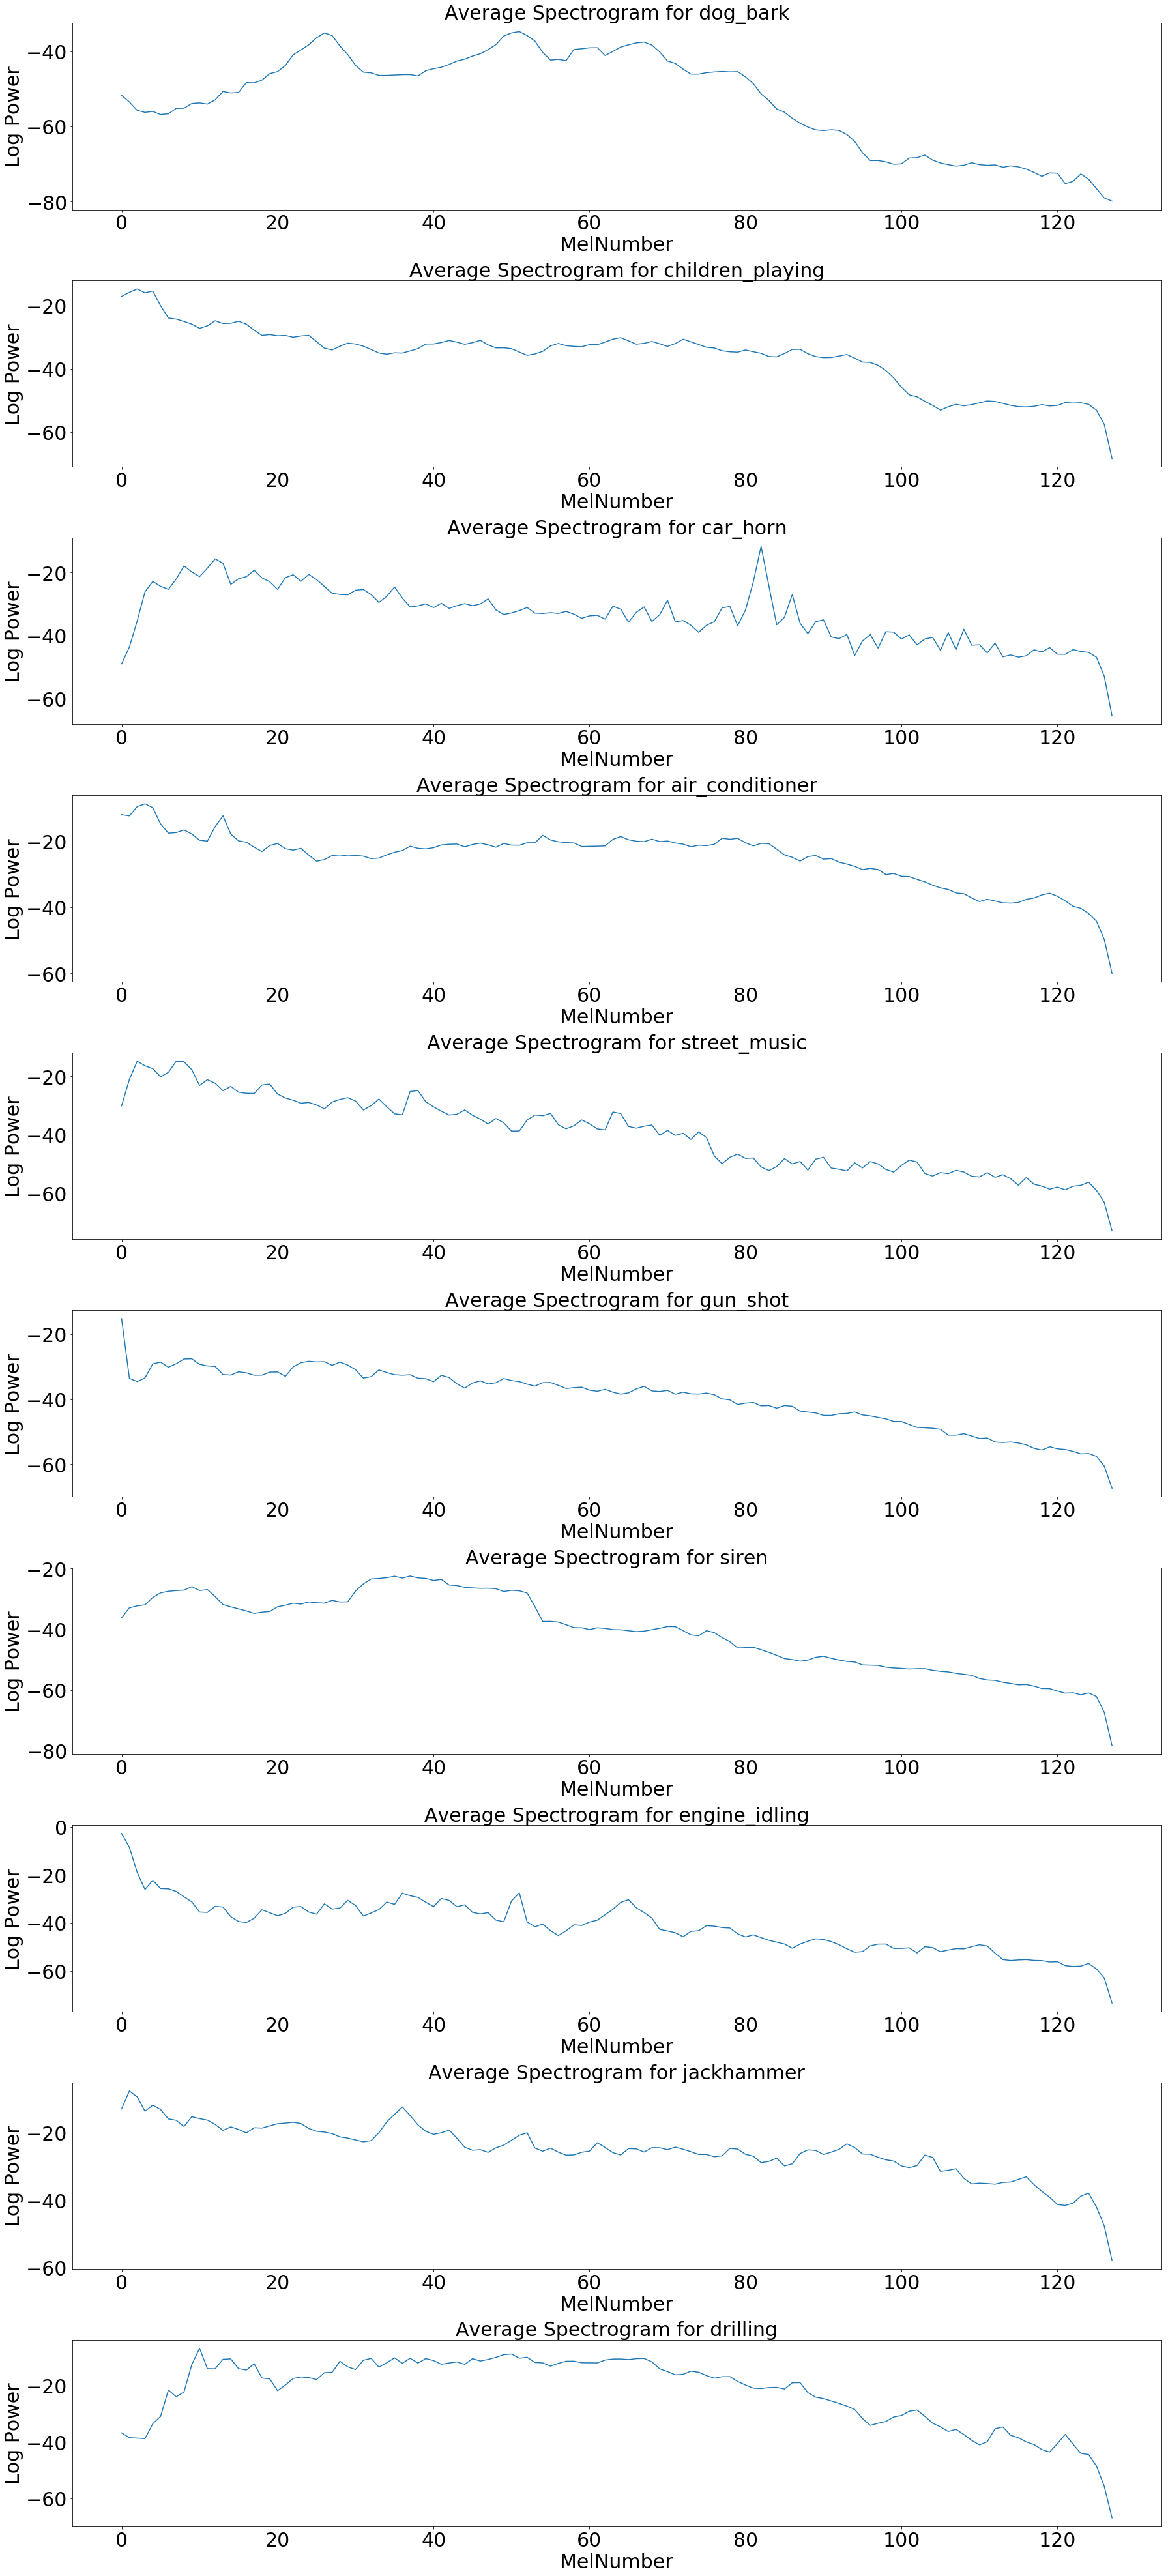

In [68]:
f, axs = plt.subplots(10,1,figsize=(25,55))
fsize=30
for j,label in enumerate(labels):
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='../Cap1/AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr,_=urbanNoises.read_audio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)
        S=lb.power_to_db(S,ref=np.max)
        S=S.mean(axis=1)
        plt.subplot(10,1,i+j+1)
        plt.plot(S)
        plt.xlabel('MelNumber',fontsize=fsize)
        plt.ylabel('Log Power',fontsize=fsize)
        plt.title('Average Spectrogram for {}'.format(label),fontsize=fsize)
        plt.tick_params(labelsize=fsize)
        

plt.tight_layout()
plt.savefig('plots/TemporalAveraging.png')
plt.show()